<a href="https://colab.research.google.com/github/willewiik/Text-Mining/blob/main/pythonscript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/willewiik/text-mining.git
%cd "text-mining"

Cloning into 'text-mining'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 39 (delta 13), reused 25 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 903.15 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/text-mining


In [6]:
# FROM CHATPGT, how to convert R lists.RDS to Python dict
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate pandas conversion for data frames if needed
pandas2ri.activate()

# Load the RDS file
readRDS = ro.r['readRDS']
list_report = readRDS("combined_stats_report_list.RDS")

# Convert R list to Python list
list_report_py = list(list_report)

# If elements are R lists, convert them to Python dicts
list_report_py = [
    dict(zip(item.names, list(item))) if hasattr(item, "names") else list(item)
    for item in list_report_py
]

In [7]:
print(type(list_report_py))
print(len(list_report_py))
print(type(list_report_py[0]))
if isinstance(list_report_py[0], dict):
    print(list_report_py[0].keys())  # List the keys of the first dictionary

for key, value in list_report_py[0].items():
    print(f"{key}: {value}")

<class 'list'>
158
<class 'dict'>
dict_keys(['hteam', 'ateam', 'starttime', 'score', 'home_players', 'away_players', 'report'])
hteam: [1] "Manchester United"

ateam: [1] "Fulham"

starttime: [1] "2024-08-16T19:00:00.000Z"

score: [1 0]
home_players:          ID                Name Position FotMob.rating Minutes.played Goals  \
1    611491         Andre Onana  Starter           8.7             90     0   
2    775539   Noussair Mazraoui  Starter           7.8             81     0   
3    255610       Harry Maguire  Starter          7.66             81     0   
4    847983   Lisandro Martinez  Starter          7.63             90     0   
5    751550         Diogo Dalot  Starter          7.68             90     0   
6    208494            Casemiro  Starter          8.01             90     0   
7   1292810       Kobbie Mainoo  Starter          7.79             84     0   
8   1070052         Amad Diallo  Starter          7.03             61     0   
9    750032         Mason Mount  Start

In [12]:
import pandas as pd
from transformers import pipeline

# Example Data: Sentences and Players
sentences = [
    "Harry Kane scored a stunning goal in the 30th minute.",
    "Kane was a constant threat to the opposition defense.",
    "Son Heung-min played exceptionally well, providing an assist.",
    "Son's dribbling was mesmerizing throughout the match.",
    "Romero's defense was rock solid.",
    "Romero made several crucial tackles.",
    "Lloris made a crucial save to deny the opposition.",
]

player_names = {
    "Harry Kane": "Kane",
    "Son Heung-min": "Son",
    "Cristian Romero": "Romero",
    "Hugo Lloris": "Lloris",
}

# Sentiment Analysis Model
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Match sentences to players
results = []

for sentence in sentences:
    for full_name, surname in player_names.items():
        if full_name in sentence or surname in sentence:
            sentiment = sentiment_model(sentence)[0]
            results.append({
                "Player": full_name,
                "Sentence": sentence,
                "Sentiment": sentiment["label"],
                "Score": sentiment["score"]
            })
            break  # Avoid assigning the same sentence to multiple players

# Convert results to DataFrame
df = pd.DataFrame(results)

# Calculate average sentiment score for each player
average_scores = df.groupby("Player").agg(
    Average_Score=("Score", "mean"),
    Sentiment_Count=("Score", "count")
).reset_index()

# Merge average scores back with the detailed DataFrame if needed
detailed_with_averages = pd.merge(df, average_scores, on="Player")

# Display Results
print(detailed_with_averages)


Device set to use cpu


            Player                                           Sentence  \
0       Harry Kane  Harry Kane scored a stunning goal in the 30th ...   
1       Harry Kane  Kane was a constant threat to the opposition d...   
2    Son Heung-min  Son Heung-min played exceptionally well, provi...   
3    Son Heung-min  Son's dribbling was mesmerizing throughout the...   
4  Cristian Romero                   Romero's defense was rock solid.   
5  Cristian Romero               Romero made several crucial tackles.   
6      Hugo Lloris  Lloris made a crucial save to deny the opposit...   

  Sentiment     Score  Average_Score  Sentiment_Count  
0   LABEL_2  0.949972       0.789618                2  
1   LABEL_0  0.629263       0.789618                2  
2   LABEL_2  0.953478       0.959687                2  
3   LABEL_2  0.965895       0.959687                2  
4   LABEL_2  0.887097       0.726608                2  
5   LABEL_2  0.566119       0.726608                2  
6   LABEL_1  0.646724  

In [11]:
match_report = """
Harry Kane scored a stunning goal in the 30th minute.
Son Heung-min played exceptionally well, providing two assists.
Cristian Romero's defense was rock solid, but Hugo Lloris made a critical save in the second half.
The team's overall performance was outstanding.
Kane was beutiful today.
"""

# Split match report into sentences
sentences = re.split(r'(?<=\.)\s+', match_report.strip())

# Filter sentences mentioning only one player
filtered_data = []
for sentence in sentences:
    mentions = [player for player in players if player in sentence]
    if len(mentions) == 1:
        filtered_data.append({"Player": mentions[0], "Sentence": sentence})


filtered_data


[{'Player': 'Harry Kane',
  'Sentence': 'Harry Kane scored a stunning goal in the 30th minute.'},
 {'Player': 'Son Heung-min',
  'Sentence': 'Son Heung-min played exceptionally well, providing two assists.'}]

In [29]:
import re
import pandas as pd
from transformers import pipeline

# Sentiment Analysis Model
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Sentiment label translation
label_translation = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# Sentiment to numerical score mapping
sentiment_to_score = {
    "negative": -1,
    "neutral": 0,
    "positive": 1
}

# Function to extract and aggregate sentiment for players
def extract_and_aggregate_sentiment(report, home_players, away_players):
    # Step 1: Tokenize the report into sentences
    sentences = re.split(r'(?<=[.!?]) +', report)

    # Step 2: Initialize player_sentiments dictionary, including only players
    # who played more than 9 minutes (needs minimum of 10 minutes to get a fotmob score)
    player_names = {
        player['Name']: player['Name'].split()[-1]  # Map full name to surname
        for player in home_players + away_players
        if int(player.get('Minutes.played', 0)) > 9
    }

    player_sentiments = {player: [] for player in player_names}  # Initialize aggregation structure

    # Step 3: Analyze each sentence
    for sentence in sentences:
        # Find players mentioned in the sentence
        players_in_sentence = [
            full_name for full_name, surname in player_names.items()
            if full_name in sentence or surname in sentence
        ]

        # Process the sentence if exactly one player is mentioned
        if len(players_in_sentence) == 1:
            full_name = players_in_sentence[0]  # Get the full name of the mentioned player
            sentiment = sentiment_model(sentence)[0]

            # Translate sentiment label and map to numerical score
            translated_sentiment = label_translation.get(sentiment["label"], sentiment["label"])
            sentiment_score = sentiment_to_score[translated_sentiment]

            # Append sentiment score to the player's list
            player_sentiments[full_name].append(sentiment_score)

    # Step 4: Aggregate sentiments for each player
    aggregated_results = []
    for player, scores in player_sentiments.items():
        if scores:  # If the player has sentiment scores
            avg_score = sum(scores) / len(scores)  # Calculate the average sentiment score
            if avg_score > 0:
                aggregated_sentiment = "positive"
            elif avg_score < 0:
                aggregated_sentiment = "negative"
            else:
                aggregated_sentiment = "neutral"

            aggregated_results.append({
                "Player": player,
                "Average Sentiment": aggregated_sentiment,
                "Scores": scores  # Include raw scores for debugging
            })


    return pd.DataFrame(aggregated_results)


Device set to use cpu


In [17]:
# Example data
report = (
    "John Doe played exceptionally well. Smith struggled to keep up, he was shit. "
    "The team captain, John Doe, scored the winning goal! Jane Smith made a great pass."
)
home_players = [
    {"Name": "John Doe", "Minutes.played": "90"},
    {"Name": "Jane Smith", "Minutes.played": "85"}
]
away_players = [
    {"Name": "Mark Lee", "Minutes.played": "75"},
    {"Name": "Emily Brown", "Minutes.played": "15"}
]

# Extract and aggregate sentiment
df_aggregated_results = extract_and_aggregate_sentiment(report, home_players, away_players)

# Display the results
print(df_aggregated_results)


       Player Average Sentiment   Scores
0    John Doe          positive   [1, 1]
1  Jane Smith           neutral  [-1, 1]


In [49]:
# TEST of the first report, Manchester United vs Fulham, 16 aug, 21:00
first_report = list_report_py[157]

# Convert the R StrVector to a native Python string
report_text = str(first_report['report'][0])  # If it's a single-element StrVector
report_text_cleaned = report_text.replace("\xa0", " ").strip()

# Convert DataFrames to lists of dictionaries
home_players = first_report['home_players'].to_dict('records')
away_players = first_report['away_players'].to_dict('records')


sentiments = extract_and_aggregate_sentiment(
    report_text_cleaned,
    home_players,
    away_players
)

all_players = home_players + away_players
player_ratings = {player['Name']: player.get('FotMob.rating', None) for player in all_players}

# Add FotMob ratings to the sentiments DataFrame
sentiments['FotMob Rating'] = sentiments['Player'].map(player_ratings)

print(sentiments)

             Player Average Sentiment       Scores FotMob Rating
0  Mateus Fernandes           neutral          [0]          6.16
1         Pape Sarr           neutral       [0, 0]          8.89
2    James Maddison          negative  [0, -1, -1]          9.16


In [48]:
# Initialize an empty list to store results for all matches
all_sentiments = []

# Iterate over all reports in the list
for report in list_report_py:
    # Extract and clean the report text
    report_text = str(report['report'][0])  # If it's a single-element StrVector
    report_text_cleaned = report_text.replace("\xa0", " ").strip()

    # Convert DataFrames to lists of dictionaries
    home_players = report['home_players'].to_dict('records')
    away_players = report['away_players'].to_dict('records')

    # Run sentiment extraction and aggregation
    sentiments = extract_and_aggregate_sentiment(
        report_text_cleaned,
        home_players,
        away_players
    )

    # Skip if sentiments is empty
    if sentiments.empty:
        continue

    # Combine players and create a mapping for FotMob ratings
    all_players = home_players + away_players
    player_ratings = {player['Name']: player.get('FotMob.rating', None) for player in all_players}

    # Add FotMob ratings to the sentiments DataFrame
    sentiments['FotMob Rating'] = sentiments['Player'].map(player_ratings)

    # Append the sentiments DataFrame to the list
    all_sentiments.append(sentiments)

# Combine all results into a single DataFrame
final_sentiments = pd.concat(all_sentiments, ignore_index=True)



                Player Average Sentiment            Scores FotMob Rating
0    Noussair Mazraoui          positive               [1]           7.8
1          Mason Mount           neutral               [0]          6.46
2       Joshua Zirkzee          positive  [1, 1, 1, -1, 0]          7.34
3           Bernd Leno          negative       [-1, -1, 1]          7.22
4     Omari Hutchinson           neutral               [0]          6.63
..                 ...               ...               ...           ...
607       Bryan Mbeumo           neutral               [0]          7.76
608     Fabio Carvalho           neutral               [0]          6.41
609   Mateus Fernandes           neutral               [0]          6.16
610          Pape Sarr           neutral            [0, 0]          8.89
611     James Maddison          negative       [0, -1, -1]          9.16

[612 rows x 4 columns]


<ipython-input-52-86d4dd02e4ef>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_sentiments, x='Average Sentiment', y='FotMob Rating', palette='Set2')


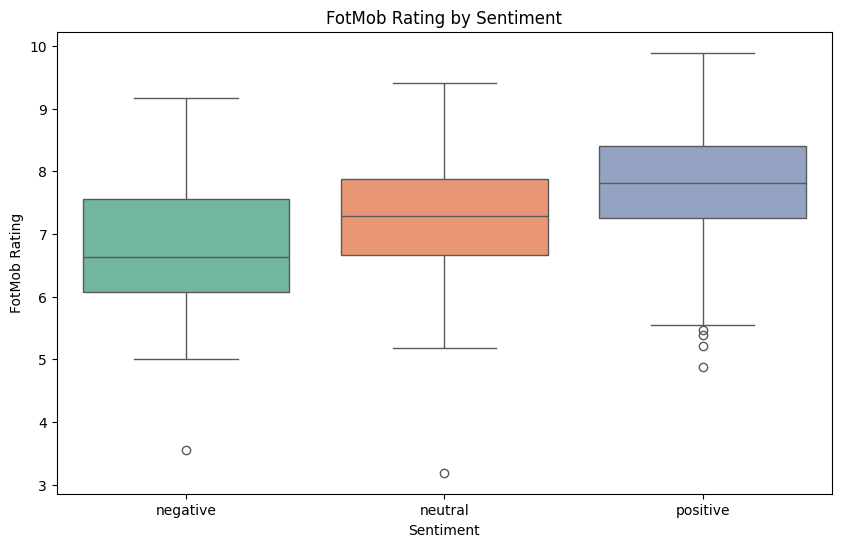

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure the 'Average Sentiment' column is categorized as 'positive', 'neutral', 'negative'
final_sentiments['Average Sentiment'] = final_sentiments['Average Sentiment'].astype('category')
final_sentiments['FotMob Rating'] = pd.to_numeric(final_sentiments['FotMob Rating'], errors='coerce')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_sentiments, x='Average Sentiment', y='FotMob Rating', palette='Set2')

# Add titles and labels
plt.title('FotMob Rating by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('FotMob Rating')

# Show the plot
plt.show()
